In [272]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [273]:
np.random.seed(4747)

## Introducing, A Fully-Connected NN Model to Predict Temperature-anomaly based off Latitude, Longitude, Elevation, Species, Year, and d18O.

In [274]:
df = pd.read_csv('../../data_with_temp/all_coral_with_temp_fixed_1880-2012.csv')
df = df.drop('Unnamed: 0.1', 1)
df

,Unnamed: 0,lat,lon,elevation,species,year,d18o,temp_anom
0,0,11.170000,119.150000,-4,Montastaea faveolata,1927,-4.067500,-0.405418
1,1,11.170000,119.150000,-4,Montastaea faveolata,1928,-3.865000,-0.503512
2,2,11.170000,119.150000,-4,Montastaea faveolata,1929,-3.865000,-0.819141
3,3,11.170000,119.150000,-4,Montastaea faveolata,1930,-4.007500,-0.337399
4,4,11.170000,119.150000,-4,Montastaea faveolata,1931,-4.040000,-0.099585
...,...,...,...,...,...,...,...,...
9693,16816,20.666667,296.833333,-5,Porites sp.,2008,-5.474000,0.210579
9694,16817,20.666667,296.833333,-5,Porites sp.,2009,-5.249917,0.288014
9695,16818,20.666667,296.833333,-5,Porites sp.,2010,-5.299417,0.664223
9696,16819,20.666667,296.833333,-5,Porites sp.,2011,-5.397417,0.425456


Fixing typos acquired from the original text scraping.

In [275]:
df = df.replace(to_replace ="Porites.sp",
                 value ="Porites sp.")
df = df.replace(to_replace ="Porites.sp",
                 value ="Porites sp.")
df = df.replace(to_replace ="Montastaea faveolata",
                 value ="Montastraea faveolata")
df = df.replace(to_replace ="Montastraea faviolata",
                 value ="Montastraea faveolata")         
df = df.replace(to_replace ="Porites australiensis",
                 value ="Porites australiensus") 
         

One-hot encoding of the species.

In [276]:
encoder_df = pd.get_dummies(df[['species']], prefix='species')
df = df.join(encoder_df)
df

,Unnamed: 0,lat,lon,elevation,species,year,d18o,temp_anom,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0,11.170000,119.150000,-4,Montastraea faveolata,1927,-4.067500,-0.405418,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,11.170000,119.150000,-4,Montastraea faveolata,1928,-3.865000,-0.503512,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,11.170000,119.150000,-4,Montastraea faveolata,1929,-3.865000,-0.819141,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,11.170000,119.150000,-4,Montastraea faveolata,1930,-4.007500,-0.337399,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,11.170000,119.150000,-4,Montastraea faveolata,1931,-4.040000,-0.099585,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9693,16816,20.666667,296.833333,-5,Porites sp.,2008,-5.474000,0.210579,0,0,...,0,0,0,0,0,1,0,0,0,0
9694,16817,20.666667,296.833333,-5,Porites sp.,2009,-5.249917,0.288014,0,0,...,0,0,0,0,0,1,0,0,0,0
9695,16818,20.666667,296.833333,-5,Porites sp.,2010,-5.299417,0.664223,0,0,...,0,0,0,0,0,1,0,0,0,0
9696,16819,20.666667,296.833333,-5,Porites sp.,2011,-5.397417,0.425456,0,0,...,0,0,0,0,0,1,0,0,0,0


Now, we want to predict `temp`, given `species`, `year`, `d18O`, `lat`, and `long`.

First, let's configure all the data into one big dataframe. But only for years after 1960 (those are the temperature years we're pretty sure about). We will want to save the data with years before 1960 as part of our test data.

Then, let's scale everything between 1 and 0 to make it more suitable for the neural network.

In [277]:
cols_to_use = ['lat', 'lon', 'elevation', 'd18o', 'year']
cols_to_use.extend(list(encoder_df.columns))

df_1960 = df[df['year']<2021]
df_1960 = df_1960[df_1960['year']>1959]

df_1960 = df_1960.dropna() # this removes a TON of data.... we should find a way to not have remove all the NaNs and instead fill them with something
df_1960 = df_1960.reset_index()
df_1960 = df_1960.drop(columns = ['index'])
df_1960 

X = df_1960[cols_to_use]
Y = df_1960['temp_anom']

In [278]:
X = X.reset_index()
X = X.drop(columns = ['index', 'elevation'])
X 

,lat,lon,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,species_Montastraea faveolata,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,11.170000,119.150000,-3.777500,1960,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,11.170000,119.150000,-4.152500,1961,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,11.170000,119.150000,-4.022500,1962,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,11.170000,119.150000,-3.672500,1963,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,11.170000,119.150000,-3.912500,1964,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,20.666667,296.833333,-5.474000,2008,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2865,20.666667,296.833333,-5.249917,2009,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2866,20.666667,296.833333,-5.299417,2010,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2867,20.666667,296.833333,-5.397417,2011,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Remove any missing/filler data points for `year` and `elevation`.

In [279]:
X = X[X['year'].notna()]
X = X[X['year']!='-999']
X = X[X['year']!='NAN']

# X = X[X['elevation'].notna()]
# X = X[X['elevation']!='-999']
# X = X[X['elevation']!='NAN']
# X['elevation'] = X['elevation'].apply(lambda x: x.strip('m'))

# X['elevation'] = X['elevation'].apply(lambda x: float(x))
X['year'] = X['year'].apply(lambda x: float(x))

Scale all the input variables between -1 and 1.

In [280]:
from sklearn import preprocessing

In [281]:
# plt.scatter(X['lon'], X['lat'])

In [282]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

cols = X.columns
# = scaler.fit_transform(X)
# X_scaled = pd.DataFrame(d, columns=cols)

X_scaled = pd.DataFrame(columns=cols)
X_scaled[encoder_df.columns] = X[encoder_df.columns]

# standardize the year separately
X_scaled['year'] = (X['year'] - 1946) / 66

X_scaled['lon'] = (X['lon'] - 180) / 180
X_scaled['lat']= (X['lat'] / 30)

# and actually, don't scale d18o
X_scaled['d18o'] = X['d18o']
X_scaled.head()


,lat,lon,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,species_Montastraea faveolata,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0.372333,-0.338056,-3.7775,0.212121,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.372333,-0.338056,-4.1525,0.227273,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.372333,-0.338056,-4.0225,0.242424,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.372333,-0.338056,-3.6725,0.257576,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.372333,-0.338056,-3.9125,0.272727,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [283]:
Y = Y.reset_index()
Y = Y.drop(columns = ['index'])
Y 

,temp_anom
0,-0.284105
1,-0.504643
2,-0.531974
3,-0.755829
4,-0.417459
...,...
2864,0.210579
2865,0.288014
2866,0.664223
2867,0.425456


Let's train a model to predict temp within the range 1960 - 2012.

In [284]:
from sklearn.model_selection import train_test_split
X_train_80, X_val_and_test_20, Y_train_80, Y_val_and_test_20 = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=47)

In [285]:
X_val_and_test_20.shape, Y_val_and_test_20.shape

((574, 24), (574, 1))

In [286]:
X_val_and_test_20.index, Y_val_and_test_20.index

(Int64Index([ 462, 2305,  366, 1031, 1868,  633, 1437, 1793, 1110, 2051,
             ...
              133,  408,  742,  185,  305,   71, 2576, 2150, 2789, 1155],
            dtype='int64', length=574),
 Int64Index([ 462, 2305,  366, 1031, 1868,  633, 1437, 1793, 1110, 2051,
             ...
              133,  408,  742,  185,  305,   71, 2576, 2150, 2789, 1155],
            dtype='int64', length=574))

In [287]:
X_train_80.shape, Y_train_80.shape

((2295, 24), (2295, 1))

In [288]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [289]:
from numpy.random import seed
seed(47)

## Full-Connected Neural Network

Next, we are going to tune a Fully-Connected NN (deep NN) using cross validation of differen parameter values. 

Original (Untuned) Network below!

In [224]:
network = Sequential()

#input layer
network.add(Dense(8, input_shape=(24,), activation='LeakyReLU'))


#middle layers
network.add(Dense(6, activation='LeakyReLU'))
network.add(Dropout(0.2))

#network.add(Dense(6, activation='LeakyReLU'))
network.add(Dense(2, activation='LeakyReLU'))

network.add(Dense(4, activation='LeakyReLU'))
network.add(Dropout(0.2))

#output layer
network.add(Dense(1, activation='LeakyReLU'))

network.compile('adam', loss='mse', metrics=['mse'])
network.fit(X_scaled, Y, epochs=50)

Epoch 1/50
90/90 [==============================] - 0s 968us/step - loss: 0.1344 - mse: 0.1344
Epoch 2/50
90/90 [==============================] - 0s 967us/step - loss: 0.1257 - mse: 0.1257
Epoch 3/50
90/90 [==============================] - 0s 851us/step - loss: 0.1230 - mse: 0.1230
Epoch 4/50
90/90 [==============================] - 0s 795us/step - loss: 0.1206 - mse: 0.1206
Epoch 5/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1174 - mse: 0.1174
Epoch 6/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1161 - mse: 0.1161
Epoch 7/50
90/90 [==============================] - 0s 995us/step - loss: 0.1120 - mse: 0.1120
Epoch 8/50
90/90 [==============================] - 0s 869us/step - loss: 0.1087 - mse: 0.1087
Epoch 9/50
90/90 [==============================] - 0s 869us/step - loss: 0.1072 - mse: 0.1072
Epoch 10/50
90/90 [==============================] - 0s 937us/step - loss: 0.1052 - mse: 0.1052
Epoch 11/50
90/90 [==============================] - 

In [225]:
network.evaluate(X_val_and_test_20, Y_val_and_test_20)

18/18 [==============================] - 0s 645us/step - loss: 0.0826 - mse: 0.0826


[0.08258718997240067, 0.08258718997240067]

This network with a dropout layer produces a teeny loss, maybe we're overfitting?

In [226]:
actual_all = pd.DataFrame(Y_val_and_test_20, columns=["temp_anom"])
predicted_all = pd.DataFrame(network.predict(X_val_and_test_20), columns=["pred"])
actual_all.head(), predicted_all.head()

(      temp_anom
 462   -0.295150
 2305   0.049835
 366   -0.409911
 1031  -0.519731
 1868  -1.026064,
        pred
 0 -0.189168
 1 -0.100777
 2 -0.000400
 3 -0.395803
 4 -0.286458)

In [227]:
predicted_all['index'] = actual_all.index
predicted_all = predicted_all.set_index(['index'])
predicted_all['index'] = actual_all.index
predicted_all = predicted_all.set_index(['index'])
predicted_all

,pred
index,
462,-0.189168
2305,-0.100777
366,-0.000400
1031,-0.395803
1868,-0.286458
...,...
71,-0.147812
2576,-0.073780
2150,-0.028158


In [228]:
actual_v_pred_all = actual_all.join(predicted_all, how = "inner")
actual_v_pred_all

,temp_anom,pred
462,-0.295150,-0.189168
2305,0.049835,-0.100777
366,-0.409911,-0.000400
1031,-0.519731,-0.395803
1868,-1.026064,-0.286458
...,...,...
71,0.124114,-0.147812
2576,-0.130982,-0.073780
2150,-0.276287,-0.028158
2789,-0.515850,-0.301287


In [229]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Y_val_and_test_20, predicted_all)

0.08258719688798477

In [230]:
test_data_with_preds = actual_v_pred_all.join(X_val_and_test_20, how = "inner")
test_data_with_preds['diff'] = test_data_with_preds['temp_anom'] - test_data_with_preds['pred']
test_data_with_preds

,temp_anom,pred,lat,lon,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,...,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni,diff
462,-0.295150,-0.189168,0.846000,-0.445389,-3.620000,0.424242,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.105982
2305,0.049835,-0.100777,-0.560667,0.995722,-0.260000,0.651515,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.150612
366,-0.409911,-0.000400,0.841100,-0.446759,-1.350000,0.696970,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.409512
1031,-0.519731,-0.395803,-0.701000,0.306944,-4.585000,0.272727,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-0.123928
1868,-1.026064,-0.286458,0.531333,0.922444,-4.820000,0.287879,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-0.739606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.124114,-0.147812,0.559000,-0.127111,-3.359167,0.227273,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.271926
2576,-0.130982,-0.073780,0.195547,-0.900667,-5.110957,0.545455,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-0.057202
2150,-0.276287,-0.028158,0.050000,0.693500,-5.234933,0.575758,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-0.248128
2789,-0.515850,-0.301287,0.195667,-0.900722,-4.822500,0.272727,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-0.214563


Text(0, 0.5, 'Predicted')

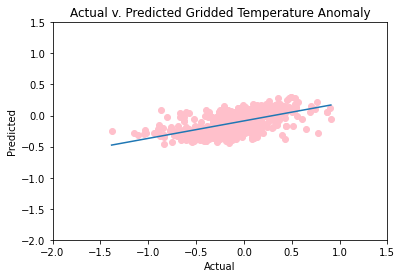

In [231]:
# x = test_data_with_preds['temp_anom']
# y = test_data_with_preds['pred']
# plt.scatter(test_data_with_preds['temp_anom'], test_data_with_preds['pred'], color="pink")
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
# plt.xlim([-2, 1.5])
# plt.ylim([-2, 1.5])
# plt.title('Actual v. Predicted Gridded Temperature Anomaly')
# plt.xlabel('Actual')
# plt.ylabel('Predicted')

Text(0, 0.5, 'Temp Error')

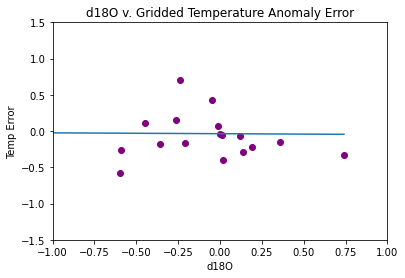

In [232]:
# x = test_data_with_preds['d18o']
# y = test_data_with_preds['diff']
# plt.scatter(test_data_with_preds['d18o'], test_data_with_preds['diff'], color="purple")
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
# plt.xlim([-1, 1])
# plt.ylim([-1.5, 1.5])
# plt.title('d18O v. Gridded Temperature Anomaly Error')
# plt.xlabel('d18O')
# plt.ylabel('Temp Error')

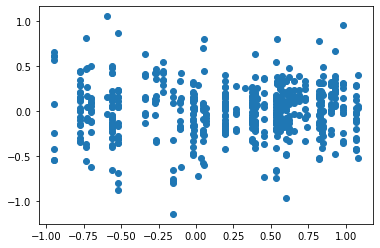

In [233]:
# plt.scatter(test_data_with_preds['lat'], test_data_with_preds['diff'])

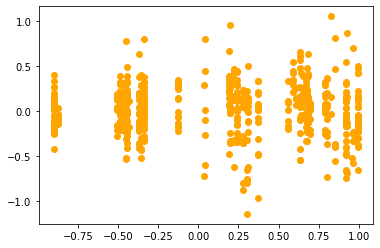

In [234]:
# plt.scatter(test_data_with_preds['lon'], test_data_with_preds['diff'], color="orange")

Let's now take all of our predictions, average them by year

<AxesSubplot:>

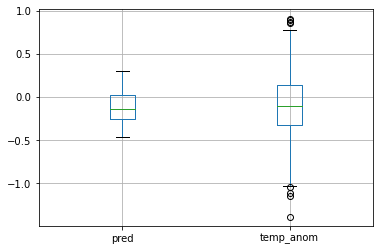

In [235]:
test_data_with_preds.boxplot(column = ['pred', 'temp_anom'])

In [236]:
annual_temp_and_preds = test_data_with_preds[['temp_anom', 'pred']].join(X, how="inner")
annual_compare = annual_temp_and_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()
annual_compare.head()

<ipython-input-236-ad8139a92e35>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  annual_compare = annual_temp_and_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()


,year,temp_anom,pred
0,1960.0,-0.214776,-0.360991
1,1961.0,-0.292462,-0.318383
2,1962.0,-0.312866,-0.311418
3,1963.0,-0.273694,-0.325247
4,1964.0,-0.469671,-0.320497


([<matplotlib.lines.Line2D at 0x7f9c7228e520>],
 [<matplotlib.lines.Line2D at 0x7f9c7228e8b0>])

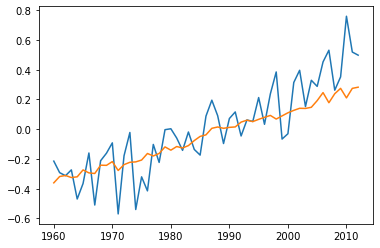

In [237]:
plt.plot(annual_compare['year'], annual_compare['temp_anom']), plt.plot(annual_compare['year'], annual_compare['pred'])

Sweet --- looks like we've at least followed the general trend of global warming :)

In [238]:
np.corrcoef(annual_compare['temp_anom'], annual_compare['pred'])

array([[1.        , 0.87062217],
       [0.87062217, 1.        ]])

In [239]:
np.var(annual_compare['temp_anom']), np.var(annual_compare['pred'])

(0.08821661774356568, 0.03538559749722481)

We should note that our predictions do not vary as much as the actual values.

In [240]:
# annual_compare.to_csv('preds_1960-2012_WITHIN.csv')

### Let's see how our model performs on the years prior to 1960.

In [241]:
cols_to_use = ['lat', 'lon', 'elevation', 'd18o', 'year']
cols_to_use.extend(list(encoder_df.columns))

df_past = df[df['year']<1960]

df_past = df_past.dropna()
df_past = df_past.reset_index()
df_past = df_past.drop(columns = ['index'])
df_past 

X_past = df_past[cols_to_use]
Y_past = df_past['temp_anom']

In [242]:
X_past = X_past.reset_index()
X_past = X_past.drop(columns = ['index'])
X_past

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,11.17,119.15,-4,-4.067500,1927,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.17,119.15,-4,-3.865000,1928,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.17,119.15,-4,-3.865000,1929,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.17,119.15,-4,-4.007500,1930,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.17,119.15,-4,-4.040000,1931,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,5.87,17.87,-10,-4.753333,1955,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4026,5.87,17.87,-10,-4.785000,1956,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4027,5.87,17.87,-10,-4.924167,1957,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4028,5.87,17.87,-10,-5.017500,1958,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [243]:
X_past = X_past[X_past['year'].notna()]
X_past = X_past[X_past['year']!='-999']
X_past = X_past[X_past['year']!='NAN']

X_past = X_past[X_past['elevation'].notna()]
X_past = X_past[X_past['elevation']!='-999']
X_past = X_past[X_past['elevation']!='NAN']
X_past['elevation'] = X_past['elevation'].apply(lambda x: x.strip('m'))

X_past['elevation'] = X_past['elevation'].apply(lambda x: float(x))
X_past['year'] = X_past['year'].apply(lambda x: float(x))
X_past

,lat,lon,elevation,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,11.17,119.15,-4.0,-4.067500,1927.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11.17,119.15,-4.0,-3.865000,1928.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.17,119.15,-4.0,-3.865000,1929.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11.17,119.15,-4.0,-4.007500,1930.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11.17,119.15,-4.0,-4.040000,1931.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,5.87,17.87,-10.0,-4.753333,1955.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4026,5.87,17.87,-10.0,-4.785000,1956.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4027,5.87,17.87,-10.0,-4.924167,1957.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4028,5.87,17.87,-10.0,-5.017500,1958.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [244]:
og_year = X_past['year']

X_past[encoder_df.columns] = X_past[encoder_df.columns]
X_past['year'] = (og_year -1946)/66

X_past['lon'] = (X_past['lon'] - 180) / 180
X_past['lat']= (X_past['lat'] / 30)

# and actually, don't scale d18o
X_past['d18o']
del X_past['elevation']
X_past.head()

,lat,lon,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,species_Isopora sp,species_Montastraea faveolata,...,species_Platygyra lamellina,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni
0,0.372333,-0.338056,-4.0675,-0.287879,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.372333,-0.338056,-3.8650,-0.272727,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.372333,-0.338056,-3.8650,-0.257576,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.372333,-0.338056,-4.0075,-0.242424,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.372333,-0.338056,-4.0400,-0.227273,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [245]:
Y_past = Y_past.reset_index()
Y_past = Y_past.drop(columns = ['index'])
Y_past 

,temp_anom
0,-0.405418
1,-0.503512
2,-0.819141
3,-0.337399
4,-0.099585
...,...
4025,-0.679975
4026,-0.700354
4027,-0.415288
4028,-0.047501


Use this functionality to convert `X_past` and `Y_past` from `nparrays` to `tensors`

In [246]:
network.predict(X_past)

array([[-0.6842145 ],
       [-0.66836303],
       [-0.6614399 ],
       ...,
       [-0.3494092 ],
       [-0.34620613],
       [-0.33814064]], dtype=float32)

In [247]:
actual_past = pd.DataFrame(Y_past, columns=["temp_anom"])
predicted_past = pd.DataFrame(network.predict(X_past), columns=["pred"])
actual_past.head(), predicted_past.head()

(   temp_anom
 0  -0.405418
 1  -0.503512
 2  -0.819141
 3  -0.337399
 4  -0.099585,
        pred
 0 -0.684214
 1 -0.668363
 2 -0.661440
 3 -0.660800
 4 -0.655310)

In [248]:
network.evaluate(X_past, Y_past)

126/126 [==============================] - 0s 607us/step - loss: 0.1899 - mse: 0.1899


[0.18987061083316803, 0.18987061083316803]

We have a much larger `test` loss than we did within the ranges of our training bounds. 

In [249]:
actual_v_pred_past = actual_past.join(predicted_past, how = "inner")
actual_v_pred_past

,temp_anom,pred
0,-0.405418,-0.684214
1,-0.503512,-0.668363
2,-0.819141,-0.661440
3,-0.337399,-0.660800
4,-0.099585,-0.655310
...,...,...
4025,-0.679975,-0.356610
4026,-0.700354,-0.351248
4027,-0.415288,-0.349409
4028,-0.047501,-0.346206


In [250]:
past_data_with_preds = actual_v_pred_past.join(X_past, how = "inner")
past_data_with_preds['diff'] = actual_v_pred_past['temp_anom'] - actual_v_pred_past['pred']
past_data_with_preds

,temp_anom,pred,lat,lon,d18o,year,species_Ceratoporella nicholsoni,species_Diploastrea heliopora,species_Diploria labyrinthiformis,species_Diploria strigosa,...,species_Porites australiensus,species_Porites lobata,species_Porites lutea,species_Porites solida,species_Porites sp.,species_Siderastrea radians,species_Siderastrea spp.,species_Sidereastrea siderea,species_Solenastrea bournoni,diff
0,-0.405418,-0.684214,0.372333,-0.338056,-4.067500,-0.287879,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.278797
1,-0.503512,-0.668363,0.372333,-0.338056,-3.865000,-0.272727,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.164851
2,-0.819141,-0.661440,0.372333,-0.338056,-3.865000,-0.257576,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.157701
3,-0.337399,-0.660800,0.372333,-0.338056,-4.007500,-0.242424,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.323401
4,-0.099585,-0.655310,0.372333,-0.338056,-4.040000,-0.227273,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.555725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,-0.679975,-0.356610,0.195667,-0.900722,-4.753333,0.136364,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-0.323366
4026,-0.700354,-0.351248,0.195667,-0.900722,-4.785000,0.151515,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-0.349106
4027,-0.415288,-0.349409,0.195667,-0.900722,-4.924167,0.166667,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-0.065878
4028,-0.047501,-0.346206,0.195667,-0.900722,-5.017500,0.181818,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.298705


([<matplotlib.lines.Line2D at 0x7f9c7273f5e0>],
 [<matplotlib.lines.Line2D at 0x7f9c7273f970>])

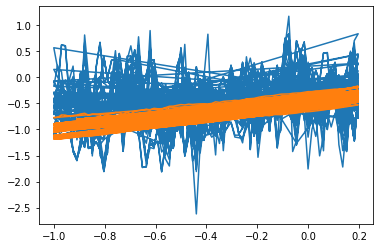

In [251]:
plt.plot(past_data_with_preds['year'], past_data_with_preds['temp_anom']), plt.plot(past_data_with_preds['year'], past_data_with_preds['pred'])

In [252]:
annual_temp_and_preds = past_data_with_preds[['temp_anom', 'pred']].join(X, how="inner")
annual_compare_past = past_data_with_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()
annual_compare_past

<ipython-input-252-fa6798582bda>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  annual_compare_past = past_data_with_preds.groupby('year', as_index=False)['temp_anom', 'pred'].mean()


,year,temp_anom,pred
0,-1.000000,-0.580696,-1.001107
1,-0.984848,-0.437284,-1.001349
2,-0.969697,-0.448660,-0.993854
3,-0.954545,-0.535872,-0.993783
4,-0.939394,-0.577859,-0.980300
...,...,...,...
75,0.136364,-0.628892,-0.385487
76,0.151515,-0.655931,-0.374619
77,0.166667,-0.272213,-0.365110
78,0.181818,-0.251039,-0.357146


In [253]:
annual_compare_past['year'] = np.arange(1880, 1960, 1)
annual_compare_past

,year,temp_anom,pred
0,1880,-0.580696,-1.001107
1,1881,-0.437284,-1.001349
2,1882,-0.448660,-0.993854
3,1883,-0.535872,-0.993783
4,1884,-0.577859,-0.980300
...,...,...,...
75,1955,-0.628892,-0.385487
76,1956,-0.655931,-0.374619
77,1957,-0.272213,-0.365110
78,1958,-0.251039,-0.357146


([<matplotlib.lines.Line2D at 0x7f9c723df700>],)

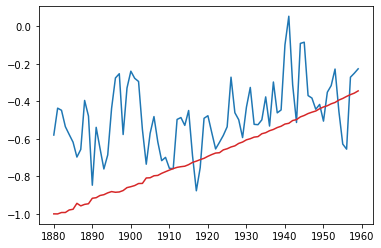

In [254]:
plt.plot(annual_compare_past['year'], annual_compare_past['temp_anom'], color = 'C0') #actual
plt.plot(annual_compare_past['year'], annual_compare_past['pred'], color = 'C3'),  #pred

In [255]:
np.corrcoef(annual_compare_past['temp_anom'], annual_compare_past['pred'])

array([[1.        , 0.40320838],
       [0.40320838, 1.        ]])

In [256]:
np.var(annual_compare_past['temp_anom']), np.var(annual_compare_past['pred'])

(0.032962245549201914, 0.03660767152905464)

In [257]:
mean_squared_error(annual_compare_past['temp_anom'], annual_compare_past['pred'])

0.08496731252895386

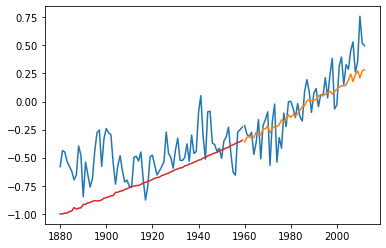

In [258]:
plt.plot(annual_compare['year'], annual_compare['temp_anom'], color = 'C0') # actual 
plt.plot(annual_compare['year'], annual_compare['pred'], color = 'C1') # prediction
plt.plot(annual_compare_past['year'], annual_compare_past['temp_anom'], color = 'C0')# actual
plt.plot(annual_compare_past['year'], annual_compare_past['pred'], color = 'C3') # prediction

Our network very much over-predicted the `temp_anom`. Probably because it over-fit to the training data which had higher temp anomalies.

In [259]:
# annual_compare.to_csv('../../models/fully_connected_nn/preds_1880-1960_OUTSIDE.csv')

In [260]:
cols_to_use = ['lat', 'lon', 'elevation', 'd18o', 'year']
cols_to_use.extend(list(encoder_df.columns))

# years from 1880 - 2020
df_all = df[df['year']<2021]
df_all = df_all[df_all['year']>1879]

# remove bad years
df_all = df_all[df_all['year'].notna()]
df_all = df_all[df_all['year']!='-999']
df_all = df_all[df_all['year']!='NAN']
df_all['year'] = df_all['year'].apply(lambda x: float(x))

df_all = df_all.dropna() # this removes a TON of data.... we should find a way to not have remove all the NaNs and instead fill them with something
df_all = df_all.reset_index()
df_all = df_all.drop(columns = ['index'])
#df_all = df_all[df_all['year']<1961]

# just grab the columns we want for the linear model
df_linear = df_all[['year', 'd18o', 'temp_anom']]
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

df_linear['d18o_scaled'] = scaler.fit_transform(df_linear['d18o'].values.reshape(-1, 1))

df_linear['linear_prediction'] = (df_linear['d18o_scaled'] / -0.22) - 1.25
df_linear
# df_all

<ipython-input-260-08e4c78f0974>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linear['d18o_scaled'] = scaler.fit_transform(df_linear['d18o'].values.reshape(-1, 1))
<ipython-input-260-08e4c78f0974>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linear['linear_prediction'] = (df_linear['d18o_scaled'] / -0.22) - 1.25


,year,d18o,temp_anom,d18o_scaled,linear_prediction
0,1927.0,-4.067500,-0.405418,-0.190693,-0.383215
1,1928.0,-3.865000,-0.503512,-0.151509,-0.561321
2,1929.0,-3.865000,-0.819141,-0.151509,-0.561321
3,1930.0,-4.007500,-0.337399,-0.179083,-0.435987
4,1931.0,-4.040000,-0.099585,-0.185372,-0.407402
...,...,...,...,...,...
6894,2008.0,-5.474000,0.210579,-0.462848,0.853856
6895,2009.0,-5.249917,0.288014,-0.419489,0.656766
6896,2010.0,-5.299417,0.664223,-0.429067,0.700303
6897,2011.0,-5.397417,0.425456,-0.448030,0.786498


In [261]:
annual_compare_linear = df_linear.groupby('year', as_index=False)['temp_anom', 'linear_prediction'].mean()
annual_compare_linear

<ipython-input-261-98a9c417d4e7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  annual_compare_linear = df_linear.groupby('year', as_index=False)['temp_anom', 'linear_prediction'].mean()


,year,temp_anom,linear_prediction
0,1880.0,-0.580696,-0.226803
1,1881.0,-0.437284,-0.351032
2,1882.0,-0.448660,-0.307324
3,1883.0,-0.535872,-0.382149
4,1884.0,-0.577859,-0.304055
...,...,...,...
129,2009.0,0.393781,0.516237
130,2010.0,0.826230,0.639430
131,2011.0,0.408003,0.571495
132,2012.0,0.520382,0.728369


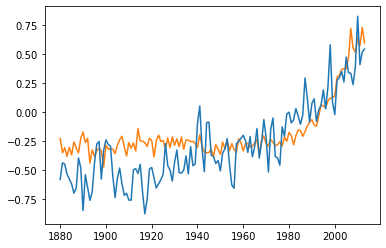

In [262]:
plt.plot(annual_compare_linear['year'], annual_compare_linear['linear_prediction'], color = 'C1') # prediction
plt.plot(annual_compare_linear['year'], annual_compare_linear['temp_anom'], color = 'C0') # prediction


In [263]:
annual_compare_linear = annual_compare_linear[annual_compare_linear['year'] < 1961]

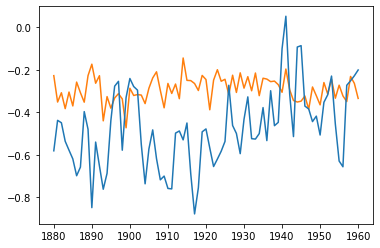

In [264]:
plt.plot(annual_compare_linear['year'], annual_compare_linear['linear_prediction'], color = 'C1') # prediction
plt.plot(annual_compare_linear['year'], annual_compare_linear['temp_anom'], color = 'C0') # prediction


In [265]:
np.corrcoef(annual_compare_linear['linear_prediction'], annual_compare_linear['temp_anom'])

array([[ 1.        , -0.07993335],
       [-0.07993335,  1.        ]])

In [266]:
np.var(annual_compare_linear['temp_anom']), np.var(annual_compare_linear['linear_prediction'])

(0.033521371065431876, 0.003501736103425206)

In [267]:
mean_squared_error(annual_compare_linear['temp_anom'],annual_compare_linear['linear_prediction'])

0.07351105306922436

### Here's another linear regression model, but this one uses all the variables and does not have a pre-formed weights.  

In [268]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()

In [269]:
linear_model.fit(X_scaled, Y)

LinearRegression()

In [270]:
preds_linear = linear_model.predict(X_past)
preds_linear

array([[-0.89077977],
       [-0.87673683],
       [-0.86272119],
       ...,
       [-0.37286189],
       [-0.35885883],
       [-0.3448369 ]])

In [271]:
linear_reg_compare = pd.DataFrame()
linear_reg_compare['preds'] = np.squeeze(preds_linear)
linear_reg_compare['temp_anom'] = Y_past
#linear_reg_compare['year'] = np.arange(1880, 1960, 1)
linear_reg_compare

,preds,temp_anom
0,-0.890780,-0.405418
1,-0.876737,-0.503512
2,-0.862721,-0.819141
3,-0.848725,-0.337399
4,-0.834714,-0.099585
...,...,...
4025,-0.400870,-0.679975
4026,-0.386859,-0.700354
4027,-0.372862,-0.415288
4028,-0.358859,-0.047501
